In [1]:
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

## This notebook has three parts:
- Generating data and visualization.
- Implementing FastICA
- Visualizing your prediction, which should be similar to S_noise

## 1. Generating data and visualization

In [2]:
n_samples = 2000
time = np.linspace(0, 8, n_samples)
s1 = np.sin(2 * time)  # sinusoidal
s2 = np.sign(np.sin(3 * time))  # square signal
s3 = signal.sawtooth(2 * np.pi * time)  # saw tooth signal

In [3]:
S_real = np.c_[s1, s2, s3]   # signal without noise

S_noise = np.c_[s1, s2, s3]  # signal with nosie
S_noise += 0.2 * np.random.normal(size=S_noise.shape)  # Add noise
S_noise /= S_noise.std(axis=0)  # Standardize data

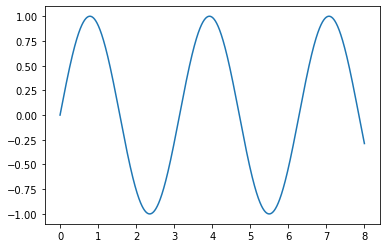

In [4]:
plt.plot(time,s1)
plt.show()

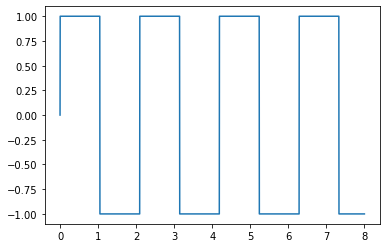

In [5]:
plt.plot(time,s2)
plt.show()

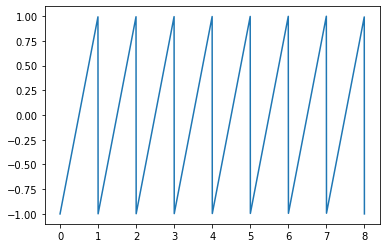

In [6]:
plt.plot(time,s3)
plt.show()

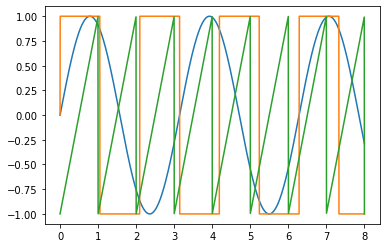

In [7]:
plt.plot(time,S_real)
plt.show()

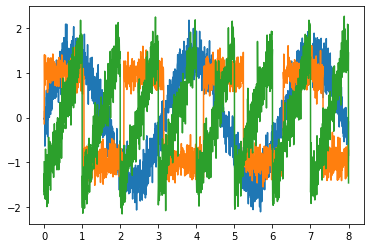

In [8]:
plt.plot(time,S_noise)
plt.show()

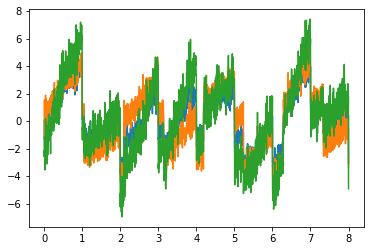

(3, 2000)


In [9]:
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S_noise, A.T)  # Generate noisy input x 
plt.plot(time,X)
plt.show()

X = X.T
print(X.shape)

## 2. FastICA
- Implement your FastICA algorithm here. 
- Feel free to define helper functions such as whiten(), g(), g_prime() et al.
- This is the **only part** that requires modification.

In [18]:
def g(x):
    return (np.tanh(x))

def g_prime(x):
    return (1 - g(x)**2)

# 1. Center X
def center(X):
    X = np.array(X)
    X_mean = X.mean(axis = 1, keepdims = True)
    return (X - X_mean)

# 2. Whiten data
def X_whiten(X):
    X_cov = np.cov(X)
    eigval, eigvec = np.linalg.eigh(X_cov)
    diag_val = np.diag(eigval)
    orthogonalval = np.sqrt(np.linalg.inv(diag_val))
    Xvec = np.dot(eigvec.T, X_center(X))
    Xwhiten = np.dot(eigvec, (np.dot(orthogonalval, Xvec)))
    return Xwhiten

def ICA(X, iterations = 1000, tol = 1e-5):
    centerX = center(X)
    whitenX = X_whiten(centerX)

    whitened_comp = whitenX.shape[0]
    # initial weights = 0
    weights = np.zeros((whitened_comp, whitened_comp), dtype = whitenX.dtype)

    for i in range(whitened_comp):
        w = np.random.rand(whitened_comp)
        for j in range(iterations):
            w_new = (whitenX * g(np.dot(w.T, whitenX))).mean(axis = 1) - g_prime(np.dot(w.T, whitenX)).mean() * w
            w_new = w_new / (np.sqrt((w_new**2).sum()))
            if i >= 1:
                w_new = w_new - np.dot(np.dot(w_new, weights[:i].T), weights[:i])
            distance = np.abs(np.abs((w * w_new).sum()) - 1)
            w = w_new
            if distance < tol:
                break
        weights[i, :] = w

    S = np.dot(weights, whitenX)
    return (S)

## 3. Prediction visualization
- Run your FastICA algorithm and visualize S, which should look like S_noise

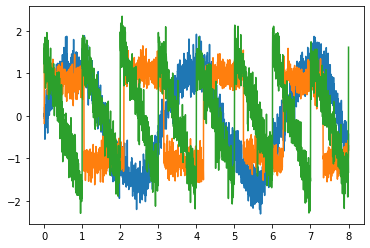

In [19]:
# run the ICA that was built above
S = ICA(X)

# plot signal to check if we get back the desired signal
for i in range(S.shape[0]):
    plt.plot(time, S[i])